In [290]:
from queries import*
from utilities import*
from scipy.spatial import Delaunay
from numpy import linalg
from sklearn import preprocessing


In [158]:
#!pip install networkx==2.5.0 python-louvain

In [159]:
#nx.__version__

## Functions

In [373]:
def get_quadratic_laplacian_forms(df,vertices,edges):
    n=len(df)
    df = min_max_scaler(df.iloc[:,1:])
    signals = df.columns
    component_graph = nx.Graph() # for a directed graph use nx.DiGraph()
    component_graph.add_nodes_from(range(len(vertices)))  # add multiple nodes at once
    component_graph.add_edges_from(edges)
    L = nx.laplacian_matrix(component_graph).A
    quad = {}
    for signal in signals:
        f = np.array(df[signal].fillna(0).values)
        inner = np.inner(f, L.dot(f))
        quad[signal] = inner
        
        
    quadtratics = pd.DataFrame(data = quad,index =[0])
        
    return  quadtratics 

In [247]:
def get_high_level_graph(high_level, thresh=None):
    """
    Get the high level delaunay triangulation graph of connected regions.
    Each region is representend by a unique node.
    ---
    Arguments :
        high_level : dataframe obtained with get_tils
        thresh : maximum distance threshold for edges
    Output :
        coord : array, node coordinates
        edges: set of edges below the threshold
    """
    coord = []
    for i, row in high_level.iterrows():
        coord.append([row.cell_x_position, row.cell_y_position])
    coord = np.array(coord)
    tri = Delaunay(coord)
    edges = set()
    dists = []
    for tr in tri.vertices:
        for i in range(3):
            edge_idx0 = tr[i]
            edge_idx1 = tr[(i+1)%3]
            if (edge_idx1, edge_idx0) in edges:
                continue  # already visited this edge from other side
            p0 = coord[edge_idx0]
            p1 = coord[edge_idx1]
            dists.append(np.linalg.norm(p1 - p0))
            if thresh is not None :
                if np.linalg.norm(p1 - p0) <  thresh:
                    edges.add((edge_idx0, edge_idx1))
            else :
                edges.add((edge_idx0, edge_idx1))
    return coord, edges


In [255]:
def project_signal(graph,signal, plot_signal= True, color='r', savefig=False,figname=''):
    laplacian_matrix = nx.laplacian_matrix(component_graph).A
    eigen_vals, eigen_vects = np.linalg.eig(laplacian_matrix)
    idx = (-eigen_vals).argsort()[::-1]   
    eigenValues = eigen_vals[idx]
    eigenVectors = eigen_vects[:,idx]
    signal = signal
    P_transpose = eigenVectors.transpose()
    projection = np.dot(P_transpose,signal)
    if plot_signal :
        fig = plt.figure(figsize=(15,7))
        plt.plot(eigenValues,projection, color='r')
        plt.grid()
        plt.ylabel("Magnitude", size="large")
        plt.xlabel("Nodes", size="large")
        plt.title(figname, size="large")
        plt.show();
        if savefig:
            fig.savefig('./plots/signals/'+ figname+'.png')
    return projection  

In [160]:
def plot_relplot(data ,x,y,color='Reds',title='',savefig=False):
    fig = sns.relplot(data=data,kind="line", x=x, y=y, height=5, aspect=3,palette=color)  
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.title(title)
    plt.show()
    if savefig :
        fig.savefig('./plots/'+title+'.png')

In [161]:
def plot_density_per_component(data,metric,components=[1,2,3],phenotypes=['T','B'], savefig=False):
    data_copy = data.copy()  
    
    filter_phenotype = data_copy[data_copy.apply(lambda x: (x.phenotype in phenotypes) and (x.component in components), axis=1)]

    fig = sns.displot(filter_phenotype,x=metric, hue="phenotype",col='component', kind="kde")
    if savefig:
        fig.savefig('./plots/density_per_component'+METRIC+'.png')

In [162]:
def order_phenotypes(pheno_1, pheno_2):
    if pheno_1 > pheno_2:
        return str(pheno_1) + '-' + str(pheno_2)
    else:
        return str(pheno_2) + '-' + str(pheno_1)

In [163]:
def scatter_plot(data, x, y, title='',  savefig=False):
    data_copy = data.copy()
    
    plt.figure(figsize=(15,7))
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    ax = sns.scatterplot(data= data_copy,x=x, y=y, palette=cmap )
    plt.grid()
    plt.title(title)    
    if savefig:
        fig.savefig('./plot/'+ title)

In [164]:
def get_subnodes(G , attribute, value : list):
    
    nodes_list = []
    
    for n in G.nodes():
        if G.nodes[n][attribute] in value :
            
            nodes_list.append(n)
            
    return nodes_list   

In [165]:
def visualize_graph(G, with_labels=False, k=None, alpha=0.1, color_attribute ='phenotype' ,node_shape='.',bipartite = False, savefig =False, figname =''):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    fig = plt.figure(figsize=(30,20))

    tumor_nodes = get_subnodes(G, 'phenotype',['tumor'])
    color_mapping = {'tumor':'darkred', 'stroma':'peru', 'T':'springgreen', 
                     'B':'turquoise','macrophages':'khaki', 'dendtritic':'orange', 'NK':'gray', 'MISSING' :'slategray'}
    if bipartite:
        pos = nx.bipartite_layout(G, tumor_nodes ,align ='vertical')
     
    else:
        pos = nx.spring_layout(G)
    
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes() ,node_color=[color_mapping[G.nodes[n][color_attribute]] for n in G.nodes()], 
                             alpha=0.8, node_shape = node_shape)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()
    if savefig:
        fig.savefig('./plots/'+figname)

In [166]:
def plot_component(graph, MIN_ELEMENTS_PER_CLUSTER= 200,component_number = 0 ,remove_stroma =False, bipartite =False, savefig=False, figname=''):
    
    components = list(nx.connected_components(graph))
    components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
    print('The cell graph contains', len(components), 'connected components')
    components = sorted(components, key=len, reverse=False)
    subgraphs = [cell_graph.subgraph(c).copy() for c in components]
    main_component = subgraphs[component_number]
    if remove_stroma :
        nodes_list =[]
        for n in main_component.nodes():
            if main_component.nodes[n]["phenotype"] != 'stroma' :
                nodes_list.append(n) 
        main_component =main_component.subgraph(nodes_list)
        
   # print(nx.info(main_component))
    visualize_graph(main_component,bipartite=bipartite, savefig=savefig, figname=figname)

In [374]:
def min_max_scaler(data):
    df = data.copy()
    columns_name = df.columns
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns = columns_name)
    
    return df

## Read data :

### Nodes 

In [167]:
nodes = pd.read_csv('data/nodes_with_border.csv')
                    
### Setting cell_id as index

nodes.set_index('cell_id', inplace=True)


### Edges : Bipartite Graph (Tumor vs other cells)
In this part we will only consider the border 

In [378]:
### Importing edges with distance threshold 100

edges = pd.read_csv('./data/edges_border.csv')

#### Fixing distance threshold and removing tumor border

#THRESHOLD = 50

#edges = graph_wrangling(edges,THRESHOLD, only_border = True)


In [383]:
edges.head(5)

,distance,cell_id_1,cell_id_2,tissue_category_1,tissue_category_2,phenotype_1,phenotype_2,is_border
0,43.811528,6821,6894,stroma,stroma,T,stroma,True
1,27.397993,34746,34779,stroma,stroma,T,stroma,False
2,40.121441,35764,35871,stroma,tumor,T,tumor,True
3,41.571384,35764,35864,stroma,tumor,T,tumor,True
4,49.064957,39869,40243,tumor,tumor,tumor,tumor,True


In [380]:
len(edges)

2031574

In [384]:
edges.describe()

,distance,cell_id_1,cell_id_2
count,2.031574e+06,2.031574e+06,2.031574e+06
mean,3.327279e+01,3.332873e+04,3.418804e+04
std,1.166505e+01,1.875347e+04,1.879219e+04
min,1.118034e+00,1.000000e+00,2.000000e+00
25%,2.482680e+01,1.701800e+04,1.780200e+04
50%,3.519730e+01,3.334600e+04,3.442400e+04
75%,4.320567e+01,4.972700e+04,5.054800e+04
max,4.999850e+01,6.553000e+04,6.553400e+04


## Edge counting and degree analysis

### Degree per tissue and phenotype

In [170]:
edges_data_grouped = edges.groupby(['cell_id_1','tissue_category_2']).agg('count')['cell_id_2'].reset_index()
degree_table = pd.pivot_table(edges_data_grouped, values='cell_id_2', index=['cell_id_1'],
                    columns=['tissue_category_2'], aggfunc=np.sum)

degree_table.columns.name = None
degree_table = degree_table.reset_index().rename( columns = {'missing':'missing_degree','tumor':'tumor_degree','stroma':'stroma_degree'})
degree_table = degree_table.fillna(0)
degree_table['total_degree'] = degree_table.apply(lambda x :  + x.tumor_degree + x.stroma_degree , axis =1)

In [171]:
phenotype_grouped = edges.groupby(['cell_id_1','phenotype_2']).agg('count')['cell_id_2'].reset_index()
phenotype_degree_table = pd.pivot_table(phenotype_grouped, values='cell_id_2', index=['cell_id_1'],
                    columns=['phenotype_2'], aggfunc=np.sum)

phenotype_degree_table.columns.name = None
phenotype_degree_table = phenotype_degree_table.fillna(0).reset_index()
cell_degree_grouped = degree_table.merge(phenotype_degree_table, on = 'cell_id_1', how = 'left')
cell_degree_grouped = cell_degree_grouped.rename(columns = {'cell_id_1':'cell_id','B':'B_degree','MISSING':'MISSING_degree','NK':'NK_degree','T':'T_degree',
                                                            'dendtritic':'dendtritic_degree','macrophages':'macrophages_degrees','stroma':'stroma_pheno_degree','tumor':'tumor_pheno_degree'
                                                           })

In [172]:
cell_degree_grouped.head()

,cell_id,missing_degree,stroma_degree,tumor_degree,total_degree,B_degree,MISSING_degree,NK_degree,T_degree,dendtritic_degree,macrophages_degrees,stroma_pheno_degree,tumor_pheno_degree
0,13,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1,254,0.0,0.0,26.0,26.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,22.0
2,261,0.0,0.0,34.0,34.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,28.0
3,276,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [173]:
nodes = nodes.merge(cell_degree_grouped, on='cell_id',how='left')

## Building the graph

In [174]:
cell_graph =nx.from_pandas_edgelist(edges, 'cell_id_1', 'cell_id_2', edge_attr=None, create_using= nx.Graph())
describe_graph(cell_graph)

Name: 
Type: Graph
Number of nodes: 22123
Number of edges: 83287
Average degree:   7.5294
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0003
Global clustering coefficient aka Transitivity: 0.0002


### Adding singular edges

### Degree distribution

In [175]:
#plot_degree_distribution(cell_graph,savefig = True, figname = 'Degreed_itribution_bipartite.png' )

### Adding nodes attributes

In [176]:
nx.set_node_attributes(cell_graph, nodes['cell_x_position'].to_dict(), 'x_position' )
nx.set_node_attributes(cell_graph, nodes['cell_y_position'].to_dict(), 'y_position' )
nx.set_node_attributes(cell_graph, nodes['tissue_category'].to_dict(), 'tissue_category' )
nx.set_node_attributes(cell_graph, nodes['phenotype'].to_dict(), 'phenotype' )
nx.set_node_attributes(cell_graph, nodes['on_border'].to_dict(), 'border' )


In [177]:
cell_graph.nodes[35980]

{'x_position': 19056.4,
 'y_position': 38731.5,
 'tissue_category': 'tumor',
 'phenotype': 'tumor',
 'border': True}

### Connected components

In [178]:
components = list(nx.connected_components(cell_graph))
print('The cell graph contains', len(components), 'connected components')

The cell graph contains 124 connected components


In [179]:
largest_comp = max(components, key=len)
percentage_lcc = len(largest_comp)/cell_graph.number_of_nodes() * 100
print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')

The largest component has 2418 nodes accounting for 10.93 % of the nodes


### Filtering components

In [180]:
MIN_ELEMENTS_PER_CLUSTER = 1
components = filtering_components(components, MIN_ELEMENTS_PER_CLUSTER)
components = sorted(components, key=len, reverse=False)

In [181]:
len(components)

124

### Betweeness Centrality T_cells and B_Cells
Betweenness centrality of a node 𝑣 is the sum of the fraction of all-pairs shortest paths that pass through 𝑣

$c_{B}(v)=\sum_{s, t \in V} \frac{\sigma(s, t \mid v)}{\sigma(s, t)}$

In [182]:
t_b_nk_cells = get_subnodes(cell_graph,'phenotype',['T','B','NK','macrophages', 'dendtritic','MISSING'])
tumor_cells = get_subnodes(cell_graph,'phenotype',['tumor'])
bc = nx.betweenness_centrality_subset(cell_graph, t_b_nk_cells ,tumor_cells)

In [183]:
cell_bc_df = pd.DataFrame(bc.items(),columns=['cell_id','betweeness_centrality'])

In [184]:
len(cell_bc_df)

22123

In [185]:
nodes = nodes.merge(cell_bc_df, on ='cell_id', how='left')

### Clustering coefficient

Compute the clustering coefficient for nodes.
For unweighted graphs, the clustering of a node $u$ is the fraction of possible triangles through that node that exist,
$$
c_{u}=\frac{2 T(u)}{\operatorname{deg}(u)(\operatorname{deg}(u)-1)}
$$
where $T(u)$ is the number of triangles through node $u$ and $\operatorname{deg}(u)$ is the degree of $u$.

In [186]:
#nodes_of_interest = get_subnodes(cell_graph,'phenotype',['T','B','NK','macrophages', 'dendtritic','tumor'])
clustering_coef = nx.clustering(cell_graph)

In [187]:
clustering_df =  pd.DataFrame(clustering_coef.items(),columns=['cell_id','clustering_coef'])
nodes = nodes.merge(clustering_df, on ='cell_id', how='left')

## Plotting Betweeness centrality and clustering coefficient

In [188]:
#columns_to_plot = ['betweeness_centrality','clustering_coef','phenotype']
#phenotypes = ['T','B','NK']
#nodes_to_plot = nodes[columns_to_plot].copy()
#nodes_to_plot = nodes_to_plot[nodes_to_plot.phenotype.apply(lambda phenotype: phenotype in phenotypes)]
#nodes_to_plot = nodes_to_plot.dropna(axis=0,how='any',subset=['betweeness_centrality'] )
#fig = sns.displot(nodes_to_plot, x="betweeness_centrality", hue="phenotype", kind="kde", height =10)
#fig.savefig('./plots/density_plot_betweeness.png')

We see a positive density for negative values which is weird since the dataframe does not contain any negative value for BC : Dispolt problem from seaborn

In [189]:
#fig = sns.displot(nodes_to_plot, x="clustering_coef", hue="phenotype", kind="kde", height =10)
#fig.savefig('./plots/density_plot_clustering coefficient.png') 

### Describe graph

In [190]:
subgraphs = [cell_graph.subgraph(c).copy() for c in components]

In [191]:
#for index, component in enumerate(subgraphs):
#    print('Component number :', index)
#    print(nx.info(component))

In [192]:
map_to_component = {}

for index, component in enumerate(components) :
    
    elements_component = list(component)
    for element in elements_component:
        
        map_to_component[element] = index

    

In [193]:
nodes['component'] = nodes.reset_index()['cell_id'].apply(lambda x: map_to_component[x]if x in map_to_component.keys() else '')

In [194]:
edges['component'] = edges.cell_id_1.apply(lambda x: map_to_component[x] if x in map_to_component.keys() else '')

## Counting edges per component

In [195]:
edge_phenotype_count = edges.groupby(['component','phenotype_1','phenotype_2']).agg('count')[['cell_id_1']].reset_index().rename(columns = {'cell_id_1':'edge_count'})

In [196]:
edge_phenotype_count['edge_type'] = edge_phenotype_count.apply(lambda row : order_phenotypes(row.phenotype_1,row.phenotype_2), axis=1)

In [197]:
edge_phenotype_count = edge_phenotype_count[['component','edge_count','edge_type']]

In [198]:
edge_phenotype_count_pivotted = pd.pivot_table(edge_phenotype_count, values='edge_count', index=['component'],
                    columns=['edge_type'], aggfunc=np.sum)
edge_phenotype_count_pivotted.columns.name = None
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.reset_index()
edge_phenotype_count_pivotted = edge_phenotype_count_pivotted.fillna(0)

In [199]:
columns_of_interest = ['component','tumor-B', 'tumor-MISSING', 'tumor-NK', 'tumor-T', 'tumor-dendtritic', 'tumor-macrophages','tumor-stroma']

In [200]:
edges_of_interest = edge_phenotype_count_pivotted[columns_of_interest]

In [201]:
edges_of_interest.head()

,component,tumor-B,tumor-MISSING,tumor-NK,tumor-T,tumor-dendtritic,tumor-macrophages,tumor-stroma
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
#plot_relplot(edges_of_interest,'component','tumor-T','Reds','The of T-tumor edges across components',True)
#plot_relplot(edges_of_interest,'component','tumor-B','Reds','The of B-tumor edges across components',True)
#plot_relplot(edges_of_interest,'component','tumor-NK','Reds','The of NK-tumor edges across components',True)

We can merge the total information about edge counting but here we will restric only to tumor vs (T, B, NK,..)

In [203]:
nodes = nodes.merge(edges_of_interest, on='component',how='left')

In [204]:
nodes = nodes.fillna(0)

## Plotting nodes

### Differentiating components

In [205]:
#vis_nodes = nodes[nodes.phenotype != 'stroma']
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component').get_figure().savefig('./plots/scatter_component_no_stroma.png')

### Differentiating Tissue

In [206]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma') & (nodes.phenotype != 'tumor') & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'component', cmap =sns.color_palette("tab10")).get_figure().savefig('./plots/scatter_only_components.png')

In [207]:
#vis_nodes = nodes[(nodes.phenotype != 'stroma') & (nodes.phenotype != 'tumor') & (nodes.phenotype != 'MISSING') ]
#fig, ax = plt.subplots(figsize = (30,15))
#sns.scatterplot(data = vis_nodes , x='cell_x_position', y= 'cell_y_position', hue = 'phenotype',
                #cmap =sns.color_palette("tab10")).get_figure().savefig('./plots/scatter_phenotype_no_stroma_no_tumor.png')

## plotting component graphs

In [208]:
MIN_NUMBER_PER__COMPONENT = 1
COMPONENT_NUM = 40
REMOVE_STROMA = True
BIPARTITE = False
SAVE_FIG = True
FIG_NAME ='component_40_without_stroma'

In [209]:
#plot_component(cell_graph,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#              remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#               savefig=SAVE_FIG, figname=FIG_NAME)

## Component analysis

Since it is a bipartite graph, we are only considering the border

### Size

In [210]:
size_df = nodes.groupby('component').agg('count').sort_values('cell_id')['cell_id'].reset_index().rename(columns = {'cell_id':'size'})

In [211]:
nodes = nodes.merge(size_df, on = 'component', how ='left') 

In [212]:
nodes.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,missing_degree,stroma_degree,tumor_degree,total_degree,...,clustering_coef,component,tumor-B,tumor-MISSING,tumor-NK,tumor-T,tumor-dendtritic,tumor-macrophages,tumor-stroma,size
0,1,14040.7,37383.4,stroma,stroma,False,0.0,0.0,0.0,0.0,...,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43411
1,2,14049.6,37381.9,stroma,MISSING,False,0.0,0.0,0.0,0.0,...,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43411
2,3,14056.5,37381.9,stroma,MISSING,False,0.0,0.0,0.0,0.0,...,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43411


## Density analysis per component

In [213]:
phenotype_component_grouped = pd.DataFrame(nodes.groupby(['component','phenotype']).agg('count')['cell_id']).reset_index()

In [214]:
phenotype_component_grouped.head(3)

,component,phenotype,cell_id
0,0,stroma,2
1,1,stroma,2
2,2,stroma,2


In [215]:
phenotype_component_pivotted = pd.pivot_table(phenotype_component_grouped, values='cell_id', index=['component'],
                    columns=['phenotype'], aggfunc=np.sum)

phenotype_component_pivotted.columns.name = None

phenotype_component_pivotted = phenotype_component_pivotted.fillna(0).sort_values(['T']).reset_index()

In [216]:
phenotype_component_pivotted.head(5)

,component,B,MISSING,NK,T,dendtritic,macrophages,stroma,tumor
0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,53,0.0,1.0,0.0,0.0,0.0,0.0,20.0,55.0
2,52,0.0,0.0,0.0,0.0,0.0,1.0,5.0,69.0
3,93,0.0,1.0,0.0,0.0,0.0,0.0,31.0,118.0
4,50,0.0,3.0,0.0,0.0,0.0,0.0,28.0,43.0


In [217]:
#phenotype_component_pivotted_copy = phenotype_component_pivotted[phenotype_component_pivotted.component!='']
#plot_relplot(phenotype_component_pivotted_copy,'component','tumor','Reds','The number of tumorous cells per component',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','T','Reds','The number of T cells per component',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','B','Reds','The number of B cells per component',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','NK','Reds','The number of NK cells per component',True)


In [218]:
phenotype_component_pivotted = phenotype_component_pivotted.merge(size_df, on='component',how='left')

The cells that are not associated to a component are out of border cells which means that they interacts only with similar tissue type cells : ***Stroma-Stroma / Tumor-Tumor***

We can use this component as a baseline, and compare the density of T_Cells/ B_Cells in each component in the border.

We will consider two types of densities, density subject to the total number of cells and density subject to tumorous cells

In [219]:
phenotype_component_pivotted = phenotype_component_pivotted[phenotype_component_pivotted.tumor != 0 ].copy()

In [220]:
phenotype_component_pivotted['T_tumor_density'] = phenotype_component_pivotted['T']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['B_tumor_density'] = phenotype_component_pivotted['B']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['NK_tumor_density'] = phenotype_component_pivotted['NK']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['stroma_tumor_density'] = phenotype_component_pivotted['stroma']/phenotype_component_pivotted['tumor']
phenotype_component_pivotted['T_density'] = phenotype_component_pivotted['T']/phenotype_component_pivotted['size']
phenotype_component_pivotted['B_density'] = phenotype_component_pivotted['B']/phenotype_component_pivotted['size']
phenotype_component_pivotted['NK_density'] = phenotype_component_pivotted['NK']/phenotype_component_pivotted['size']
phenotype_component_pivotted['dendtritic_density'] = phenotype_component_pivotted['dendtritic']/phenotype_component_pivotted['size']
phenotype_component_pivotted['macrophages_density'] = phenotype_component_pivotted['macrophages']/phenotype_component_pivotted['size']


In [221]:
#plot_relplot(phenotype_component_pivotted_copy,'component','T_tumor_density','Reds','T cells density over Tumor cells',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','B_tumor_density','Reds','B cells density over Tumor cells',True)
#plot_relplot(phenotype_component_pivotted_copy,'component','NK_tumor_density','Reds','NK cells density over Tumor cells',True)

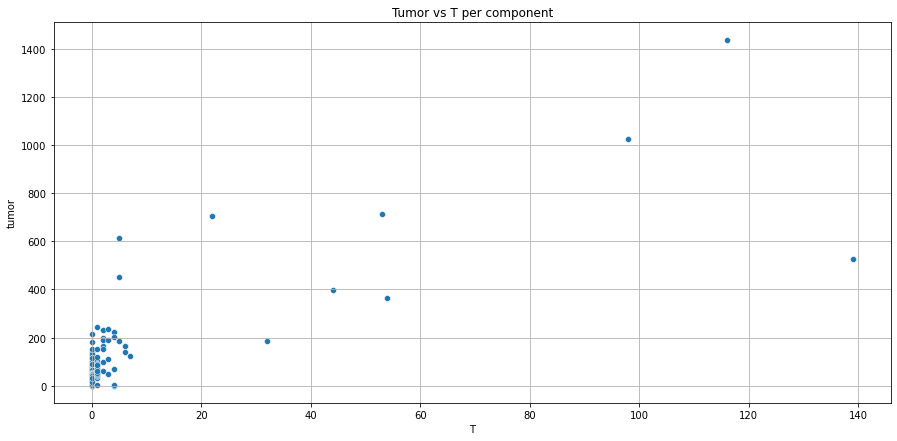

In [222]:
phenotype_component_pivotted_copy = phenotype_component_pivotted[phenotype_component_pivotted.component!='']

scatter_plot(phenotype_component_pivotted_copy, 'T','tumor',title ='Tumor vs T per component',savefig=False)

In [223]:
phenotype_component_pivotted.head(2)

,component,B,MISSING,NK,T,dendtritic,macrophages,stroma,tumor,size,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,T_density,B_density,NK_density,dendtritic_density,macrophages_density
1,53,0.0,1.0,0.0,0.0,0.0,0.0,20.0,55.0,76,0.0,0.0,0.0,0.363636,0.0,0.0,0.0,0.0,0.000000
2,52,0.0,0.0,0.0,0.0,0.0,1.0,5.0,69.0,75,0.0,0.0,0.0,0.072464,0.0,0.0,0.0,0.0,0.013333


In [224]:
MIN_NUMBER_PER__COMPONENT = 1
COMPONENT_NUM = 123
REMOVE_STROMA = False
BIPARTITE = False
SAVE_FIG = True
FIG_NAME ='component_123_with_stroma'

In [225]:
#plot_component(cell_graph,MIN_NUMBER_PER__COMPONENT,COMPONENT_NUM,
#              remove_stroma =REMOVE_STROMA,bipartite =BIPARTITE,
#              savefig=SAVE_FIG, figname=FIG_NAME)

In [226]:
nodes = nodes.merge(phenotype_component_pivotted, on='component', how='left')

## Betweeness centrality density accross Components

In [227]:
PHENOTYPES = ['T','B']
COMPONENTS = [123,122,121]
METRIC = "betweeness_centrality"

# High level Graph 

In [228]:
nodes.head(3)

,cell_id,cell_x_position,cell_y_position,tissue_category,phenotype,on_border,missing_degree,stroma_degree,tumor_degree,total_degree,...,size_y,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,T_density,B_density,NK_density,dendtritic_density,macrophages_density
0,1,14040.7,37383.4,stroma,stroma,False,0.0,0.0,0.0,0.0,...,43411.0,0.004087,0.000654,0.000163,0.160033,0.003455,0.000553,0.000138,0.000184,0.00235
1,2,14049.6,37381.9,stroma,MISSING,False,0.0,0.0,0.0,0.0,...,43411.0,0.004087,0.000654,0.000163,0.160033,0.003455,0.000553,0.000138,0.000184,0.00235
2,3,14056.5,37381.9,stroma,MISSING,False,0.0,0.0,0.0,0.0,...,43411.0,0.004087,0.000654,0.000163,0.160033,0.003455,0.000553,0.000138,0.000184,0.00235


In [229]:
nodes.columns

Index(['cell_id', 'cell_x_position', 'cell_y_position', 'tissue_category',
       'phenotype', 'on_border', 'missing_degree', 'stroma_degree',
       'tumor_degree', 'total_degree', 'B_degree', 'MISSING_degree',
       'NK_degree', 'T_degree', 'dendtritic_degree', 'macrophages_degrees',
       'stroma_pheno_degree', 'tumor_pheno_degree', 'betweeness_centrality',
       'clustering_coef', 'component', 'tumor-B', 'tumor-MISSING', 'tumor-NK',
       'tumor-T', 'tumor-dendtritic', 'tumor-macrophages', 'tumor-stroma',
       'size_x', 'B', 'MISSING', 'NK', 'T', 'dendtritic', 'macrophages',
       'stroma', 'tumor', 'size_y', 'T_tumor_density', 'B_tumor_density',
       'NK_tumor_density', 'stroma_tumor_density', 'T_density', 'B_density',
       'NK_density', 'dendtritic_density', 'macrophages_density'],
      dtype='object')

## Aggregations

In [264]:
columns_to_sum = ['component','missing_degree', 'stroma_degree', 'tumor_degree', 'total_degree',
       'B_degree', 'MISSING_degree', 'NK_degree', 'T_degree',
       'dendtritic_degree', 'macrophages_degrees', 'tumor_pheno_degree', 'stroma_pheno_degree']

columns_to_avg = ['component','cell_x_position', 'cell_y_position','betweeness_centrality', 'clustering_coef', 'tumor-B',
       'tumor-MISSING', 'tumor-NK', 'tumor-T', 'tumor-dendtritic',
       'tumor-macrophages', 'tumor-stroma', 'size_x', 'B', 'MISSING', 'NK',
       'T', 'dendtritic', 'macrophages', 'stroma', 'tumor',
       'T_tumor_density', 'B_tumor_density', 'NK_tumor_density',
       'stroma_tumor_density', 'T_density', 'B_density', 'NK_density',
       'dendtritic_density', 'macrophages_density']

In [265]:
component_nodes_sum = nodes[columns_to_sum].groupby(['component']).agg('sum').reset_index()
component_nodes_avg = nodes[columns_to_avg].groupby(['component']).agg('mean').reset_index()
component_nodes = component_nodes_sum.merge(component_nodes_avg, on='component', how ='left')

In [266]:
component_nodes.tail()

,component,missing_degree,stroma_degree,tumor_degree,total_degree,B_degree,MISSING_degree,NK_degree,T_degree,dendtritic_degree,...,tumor,T_tumor_density,B_tumor_density,NK_tumor_density,stroma_tumor_density,T_density,B_density,NK_density,dendtritic_density,macrophages_density
120,120,5.0,1791.0,1860.0,3651.0,0.0,42.0,22.0,292.0,0.0,...,704.0,0.031250,0.000000,0.001420,0.451705,0.020542,0.000000,0.000934,0.000000,0.012138
121,121,11.0,1923.0,3700.0,5623.0,247.0,48.0,2.0,510.0,35.0,...,527.0,0.263757,0.066414,0.001898,0.827324,0.119621,0.030120,0.000861,0.010327,0.007745
122,122,0.0,4806.0,5553.0,10359.0,134.0,123.0,58.0,853.0,18.0,...,1024.0,0.095703,0.014648,0.005859,0.710938,0.051552,0.007891,0.003156,0.003682,0.000000
123,123,7.0,3304.0,5666.0,8970.0,61.0,142.0,12.0,703.0,6.0,...,1438.0,0.080668,0.010431,0.002782,0.528512,0.047974,0.006203,0.001654,0.008271,0.013234
124,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,36705.0,0.004087,0.000654,0.000163,0.160033,0.003455,0.000553,0.000138,0.000184,0.002350


In [267]:
component_nodes.columns

Index(['component', 'missing_degree', 'stroma_degree', 'tumor_degree',
       'total_degree', 'B_degree', 'MISSING_degree', 'NK_degree', 'T_degree',
       'dendtritic_degree', 'macrophages_degrees', 'tumor_pheno_degree',
       'stroma_pheno_degree', 'cell_x_position', 'cell_y_position',
       'betweeness_centrality', 'clustering_coef', 'tumor-B', 'tumor-MISSING',
       'tumor-NK', 'tumor-T', 'tumor-dendtritic', 'tumor-macrophages',
       'tumor-stroma', 'size_x', 'B', 'MISSING', 'NK', 'T', 'dendtritic',
       'macrophages', 'stroma', 'tumor', 'T_tumor_density', 'B_tumor_density',
       'NK_tumor_density', 'stroma_tumor_density', 'T_density', 'B_density',
       'NK_density', 'dendtritic_density', 'macrophages_density'],
      dtype='object')

In [268]:
component_x = component_nodes.cell_x_position.values
component_y = component_nodes.cell_y_position.values
points = []
for x,y in zip(component_x,component_y):
    points.append([x,y])

points = np.array(points)    
tri = Delaunay(points)    

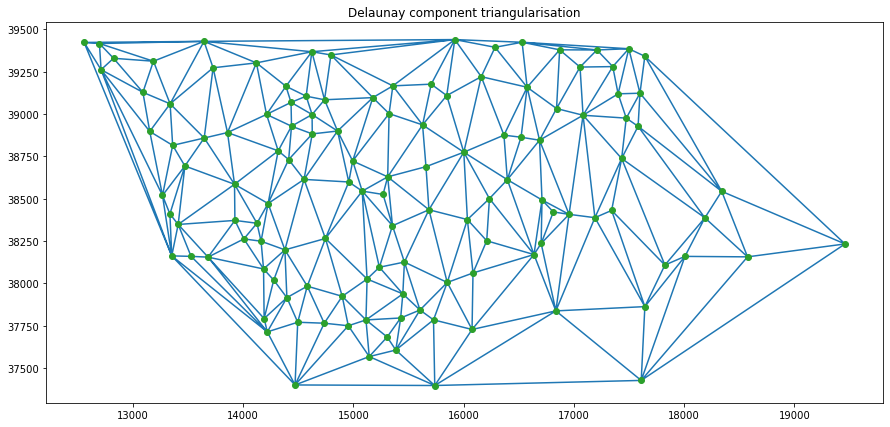

In [269]:
fig = plt.figure(figsize=(15,7))

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.title('Delaunay component triangularisation')    
plt.show()
fig.savefig('./plots/Delaunay_component_triangularisation.png')

In [270]:
threshold = 1000
vertices = component_nodes.component.values
coord, edges = get_high_level_graph(component_nodes,threshold)

In [271]:
len(vertices)

125

In [272]:
def visualize_component_graph(G, with_labels=False, k=None, alpha=1.0, node_shape='.',savefig=False,figname=''):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    fig = plt.figure(figsize=(30,20))

    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')
    if savefig:
        fig.savefig('./plots/'+figname)

### Build graph

In [273]:
component_graph = nx.Graph() # for a directed graph use nx.DiGraph()

component_graph.add_nodes_from(range(len(vertices)))  # add multiple nodes at once

component_graph.add_edges_from(edges)

#visualize_component_graph(component_graph,k=0.05, alpha=0.8,savefig=True,figname='High_level_graph_threshold_200.png')


In [274]:
laplacian_matrix = nx.laplacian_matrix(component_graph).A
eigen_vals, eigen_vects = np.linalg.eig(laplacian_matrix)

In [275]:
idx = (-eigen_vals).argsort()[::-1]   
eigenValues = eigen_vals[idx]
eigenVectors = eigen_vects[:,idx]

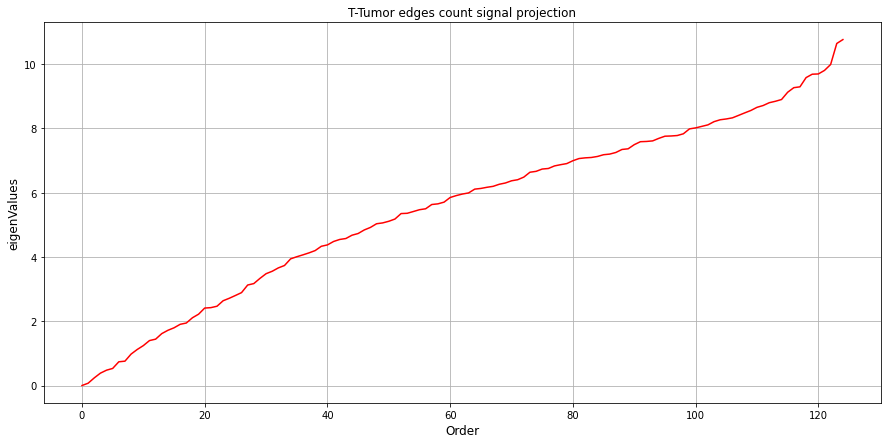

In [276]:
fig = plt.figure(figsize=(15,7))
plt.plot(eigenValues,color='r')
plt.grid()
plt.ylabel("eigenValues", size="large")
plt.xlabel("Order", size="large")

plt.title("T-Tumor edges count signal projection", size="large")
plt.show();
fig.savefig('./plots/T-Tumor edges count signal projection.png')

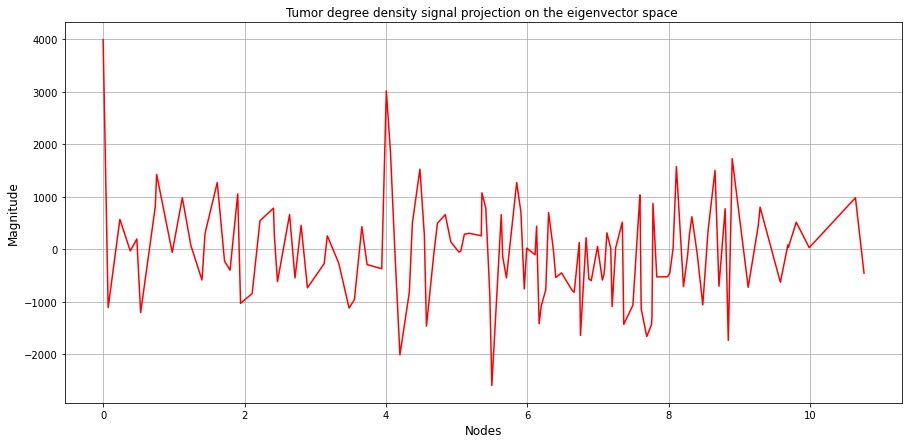

In [277]:
SIGNAL = np.array(component_nodes.tumor_degree.fillna(0).values)
GRAPH = component_graph
FIGNAME = 'Tumor degree density signal projection on the eigenvector space '
projection = project_signal(GRAPH,SIGNAL,True,'b',True,FIGNAME)

## Quadratic laplacian forms

In [354]:
quadtratics = get_quadratic_laplacian_forms(component_nodes,vertices,edges)

In [355]:
quadtratics = pd.melt(quadtratics)

In [372]:
#fig = quadtratics.sort_values(['value']).plot.bar(x='variable',y='value',rot=70,figsize =(20,10))
#plt.xlabel('Signals')
#plt.ylabel('Quadratic Laplace form')
#plt.grid()
#plt.title('Quadratic Laplace form for all signals')
#plt.savefig('./plots/signals/Quadratic Laplace form for all signals.png')